In [1]:
import numpy as np
from matplotlib import pyplot as plt
from molecular_generation_utils import *
from invert_CM import *
import torch
from Model import Multi_VAE
from torch.distributions.categorical import Categorical
from tqdm import tqdm
import copy

reproduce_paper = True

if reproduce_paper:
    paper_path = '_paper'
else:
    paper_path = ''


properties = torch.load('./data{}/data/properties_total.pt'.format(paper_path))
p_means = torch.load('./data{}/data/properties_means.pt'.format(paper_path))
p_stds = torch.load('./data{}/data/properties_stds.pt'.format(paper_path))
norm_props = (properties - p_means)/p_stds

properties_list =  ['eAT', 'eMBD', 'eXX', 'mPOL', 'eNN', 'eNE', 'eEE', 'eKIN', 'DIP', 'HLgap', 'HOMO_0', 'LUMO_0', 'HOMO_1', 'LUMO_1', 'HOMO_2', 'LUMO_2', 'dimension']
p_arr = np.array(properties_list)

PATH = './models_saved/masked/epoch=2597-step=145487.ckpt'

modello = Multi_VAE.load_from_checkpoint(
    PATH,
    map_location=torch.device('cpu'),
    structures_dim = len(torch.load('./data/data_val/CMs.pt')[0,:]),
    properties_dim = len(torch.load('./data/data_val/properties.pt')[0,:]),
    latent_size = 21,
    extra_dim = 32 - len(torch.load('./data/data_val/properties.pt')[0,:]),
    initial_lr = 1e-3,
    properties_means = p_means,
    properties_stds = p_stds,
    beta = 4.,
    alpha = 1.,
    decay = .01
)

# if you want the non-masked model uncomment this

# if reproduce_paper == True:
#     PATH='./special/VAE_reduced_21'
#     modello.VAE.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
#     PATH='./special/prop_ecoder_reduced_21'
#     modello.property_encoder.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

modello.eval()
modello.freeze()

Fit the dataset property distribution with 91 (optional number) Gaussians

In [29]:
gm, labels = props_fit_Gaussian_mix(
    norm_props, 
    min_components = 91,
    max_components = 92
    )

100%|██████████| 1/1 [02:18<00:00, 138.54s/it]


using 91 components


In [ ]:
# recall that here the target value is the normalized one

generated = start_generation(
    modello,
    {
        'mPOL': 2.,
        'eMBD': 2.
    },
    p_arr,
    11,
    int(5e3),
    gm.means_,
    gm.covariances_,
    cm_diff = 5,
    deltaz = 6,
    check_new_comp = True
    verbose = True
)

In [ ]:
# load the coulomb matrices in the dataset
CMs = torch.load('./data{}/data/CMs_total.pt'.format(paper_path))

In [142]:
#find the closest mmatrix in the dataset

where_closest = []
for cm in generated:
    where_closest.append(torch.argmin(torch.norm(CMs - cm.view(1,-1), dim = 1)))
    #print(torch.norm(CMs - cm.view(1,-1), dim = 1).min())

In [32]:
#some visualization and optimization

import rmsd
from ase.visualize import view
from ase.optimize import BFGS, FIRE
from ase import Atoms
from ase.io import write, read
from openbabel import openbabel as ob
from ase.constraints import FixAtoms

# here choose the calculator you prefer, or do not optimize by commenting out the opt steps in the code
#from spooks.spookynet import SpookyNetCalculator, spookynet
#calc=SpookyNetCalculator(load_from="./spooks/qm7x_known_unknown_0.pth", charge=0, magmom=0)

n = 0
pos, comp = get_cartesian(generated[n,:].tolist())
print(len(comp))
atom = Atoms(comp, pos)
write('./temp.xyz', atom)
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("xyz", "mol2")
mol = ob.OBMol()
obConversion.ReadFile(mol, "temp.xyz")  
obConversion.WriteFile(mol, 'temp.mol2')
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("mol2", "xyz")
mol = ob.OBMol()
obConversion.ReadFile(mol, "temp.mol2")  
mol.ConnectTheDots()
mol.PerceiveBondOrders()
mol.AddHydrogens()
obConversion.WriteFile(mol, './temp.xyz')
atom = read('./temp.xyz')
print(comp, len(comp))
c = FixAtoms(indices=[atomo.index for atomo in atom if atomo.symbol != 'H'])
atom.set_constraint(c)
atom.set_calculator(calc)
#try:
opt = FIRE(atom)
opt.run(steps = 5)
# atom.set_constraint()
# opt.run(steps = 10)
#except:
#    pass
view(atom, viewer = 'x3d')

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [129]:
# visualize the closest molecules in the dataset by coulomb matrix

import rmsd
from ase.visualize import view
from ase import Atoms

pos, comp = get_cartesian(CMs[where_closest[n],:].tolist())
print(len(comp))
atom = Atoms(comp, pos)
view(atom, viewer = 'x3d')

7


[['opt-new_mol_1                  89.152023       -0.349659      101.345923        6.679409        0.258495']
 ['opt-new_mol_2                  83.942242       -0.275254      103.457106        6.612292        0.490576']
 ['opt-new_mol_3                  81.672425       -0.320542       96.750483        6.537104        0.130669']
 ['opt-new_mol_6                  87.693071       -0.300381      100.507797        6.651634        0.531671']]
[['opt-new_mol_1-pp               97.006998       -0.433016      106.544639        6.457454        0.514589']
 ['opt-new_mol_5-pp               91.010867       -0.405348      105.686245        7.151042        0.180508']]


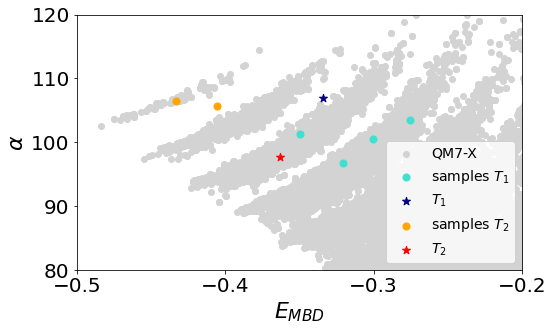

In [10]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
font = {'family' : "Times New Roman",
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
#plt.rcParams["font.family"] = "Times New Roman"

gold = (1+(5**0.5))/2
plt.figure(figsize=(5*gold,5))

plt.scatter(properties[:,1], properties[:,3], c = 'lightgrey', label = 'QM7-X')
index = [0,1,2,4]
mols = pd.read_csv('/work/projects/tcp/lmedrano/alessio/vae/mol-new/code/fhi/extract/xyzfiles2/12/data-12.dat', header = None).values[index]
print(mols)
for i in range(0, len(mols)):
    if i == 0:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'turquoise', s = 50, label = r'samples $T_1$')
    else:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'turquoise', s = 50)
        
plt.scatter(-1*p_stds[1] + p_means[1], 2*p_stds[3] + p_means[3], c = 'navy', marker = '*', s = 70, label = r'$T_1$')

mols = pd.read_csv('/work/projects/tcp/lmedrano/alessio/vae/mol-new/code/fhi/extract/xyzfiles/set2/data-set2.dat', header = None).values
print(mols)
for i in range(0, len(mols)):
    if i == 0:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'orange', s = 50, label = r'samples $T_2$')
    else:
        plt.scatter(float(mols[i][0].split()[2]), float(mols[i][0].split()[3]), c = 'orange', s = 50)
                
plt.scatter(-1.5*p_stds[1] + p_means[1], 1*p_stds[3] + p_means[3], c = 'red', marker = '*', s = 70, label = r'$T_2$')
plt.legend(loc = 'lower right', prop = {'size': 14})
plt.xlim(-.5, -.2)
plt.ylim(80, 120)
plt.locator_params(axis='x', nbins=4)
plt.locator_params(axis='y', nbins=4)
plt.xlabel(r'$E_{MBD}$', fontdict={'size':22})
plt.ylabel(r'$\alpha$', fontdict={'size':22})
plt.tight_layout()
plt.savefig('./new_chem.pdf', dpi = 100)